In [1]:
import os

import keras

from classification_models.keras import Classifiers
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense
from keras.models import Model
from keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler
from keras.metrics import top_k_categorical_accuracy
from keras.optimizers import SGD

Using TensorFlow backend.


### Configurações de treino

In [2]:
def tl_scheduler(epoch):
    if epoch < 6:
        return 0.005
    elif epoch < 11:
        return 0.001
    elif epoch < 21:
        return 0.005
    elif epoch < 28:
        return 0.001
    elif epoch < 36:
        return 0.0005
    else:
        return 0.0001


In [3]:
training_config = {
    'batch_size': 128,
    'target_size': (224,224),
    'epochs': 55,
    'lr': 0.005,
    'decay': 0,
    'seed': 42
}

### Carregando Dataset

In [4]:
experiments_path = '/data/alberto/iWildCam2020/experiments'
experiment = 'resnet18_train_balanced'

In [5]:
train_dir = '/data/alberto/iWildCam2020/balanced_resized/balanced_train_resized'
validation_dir = '/data/alberto/iWildCam2020/balanced_resized/balanced_validation_resized'

In [6]:
train_datagen = ImageDataGenerator(rotation_range=20,
                                   zoom_range=0.15,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.15,
                                   horizontal_flip=True,
                                   fill_mode="nearest")

validation_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=training_config['target_size'],
        batch_size=training_config['batch_size'],
        class_mode='categorical',
        shuffle=True,
        seed=training_config['seed'])

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=training_config['target_size'],
        batch_size=training_config['batch_size'],
        class_mode='categorical',
        classes=sorted(list(train_generator.class_indices.keys())))

Found 148355 images belonging to 3 classes.
Found 22571 images belonging to 3 classes.


### Calbacks

In [7]:
model_path = os.path.join(experiments_path, experiment, 'models', 'weights.{epoch:02d}-{val_accuracy:.2f}.hdf5')
if not os.path.exists(os.path.dirname(model_path)):
    os.makedirs(os.path.dirname(model_path))

checkpoint = ModelCheckpoint(
    filepath=model_path,
    monitor='val_accuracy'
)

checkpoint_best = ModelCheckpoint(
    filepath=os.path.join(experiments_path, experiment, 'models', 'best.hdf5'),
    save_best_only=True,
    monitor='val_accuracy'
)

csv_path = os.path.join(experiments_path, experiment, 'history', 'training.log')
if not os.path.exists(os.path.dirname(csv_path)):
    os.makedirs(os.path.dirname(csv_path))

csv_logger = CSVLogger(csv_path, append=True)

lr_scheduler = LearningRateScheduler(tl_scheduler)

In [8]:
callbacks = [checkpoint, checkpoint_best, csv_logger, lr_scheduler]

### Definindo Métricas

In [9]:
def top_5_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=5)

### Preparando modelo 

In [10]:
ResNet18, preprocess_input = Classifiers.get('resnet18')

In [11]:
base_model = ResNet18(input_shape=(224,224,3), weights='imagenet', include_top=False)
x = GlobalAveragePooling2D()(base_model.output)
output = Dense(len(validation_generator.class_indices), activation='softmax')(x)
model = Model(inputs=[base_model.input], outputs=[output])

In [12]:
for layer in model.layers:
    layer.trainable = True

In [14]:
optimizer = SGD(lr=training_config['lr'], momentum=0.9, decay=0)

In [15]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', top_5_accuracy])

In [16]:
current_epoch = 0

### Treinando modelo

In [17]:
history = model.fit_generator(
            train_generator,
            steps_per_epoch=train_generator.n // training_config['batch_size'],
            epochs=training_config['epochs'],
            validation_data=validation_generator,
            validation_steps=validation_generator.n // training_config['batch_size'],
            callbacks=callbacks,
            initial_epoch=current_epoch,
            use_multiprocessing=True,
            workers=8)

Epoch 1/55
1159/1159 [==============================] - 589s 508ms/step - loss: 0.1213 - accuracy: 0.9590 - top_5_accuracy: 1.0000 - val_loss: 0.1772 - val_accuracy: 0.9395 - val_top_5_accuracy: 1.0000
Epoch 2/55
1159/1159 [==============================] - 584s 504ms/step - loss: 0.0908 - accuracy: 0.9683 - top_5_accuracy: 1.0000 - val_loss: 0.1327 - val_accuracy: 0.9500 - val_top_5_accuracy: 1.0000
Epoch 3/55
1159/1159 [==============================] - 584s 504ms/step - loss: 0.0748 - accuracy: 0.9728 - top_5_accuracy: 1.0000 - val_loss: 0.0935 - val_accuracy: 0.9625 - val_top_5_accuracy: 1.0000
Epoch 4/55
1159/1159 [==============================] - 584s 504ms/step - loss: 0.0727 - accuracy: 0.9733 - top_5_accuracy: 1.0000 - val_loss: 0.1008 - val_accuracy: 0.9549 - val_top_5_accuracy: 1.0000
Epoch 5/55
1159/1159 [==============================] - 584s 504ms/step - loss: 0.0632 - accuracy: 0.9769 - top_5_accuracy: 1.0000 - val_loss: 0.1013 - val_accuracy: 0.9541 - val_top_5_accurac

### Analisando dados pós-treinamento

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

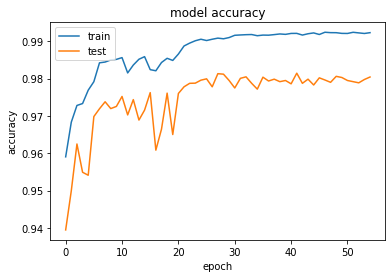

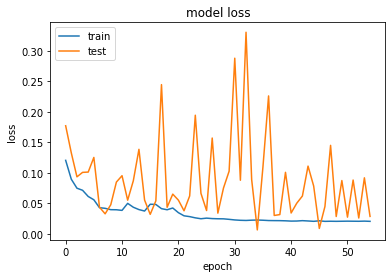

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Gerando matriz de confusão

In [20]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
Y_pred = model.predict_generator(validation_generator, validation_generator.n // training_config['batch_size']+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))

Confusion Matrix
[[5697 5589]
 [5784 5501]]


In [21]:
print('Classification Report')
target_names = ['empty', 'noempty']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

       empty       0.50      0.50      0.50     11286
     noempty       0.50      0.49      0.49     11285

    accuracy                           0.50     22571
   macro avg       0.50      0.50      0.50     22571
weighted avg       0.50      0.50      0.50     22571



In [22]:
cm=confusion_matrix(validation_generator.classes, y_pred)

Acurácia: 0.4961
Sensitividade: 0.5048
Especificidade: 0.4875


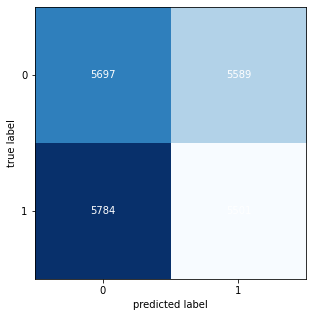

In [25]:
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

print("Acurácia: {:.4f}".format(acc))
print("Sensitividade: {:.4f}".format(sensitivity))
print("Especificidade: {:.4f}".format(specificity))

from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=cm ,  figsize=(5, 5))
plt.show()

#### Classificação Empty e NoEmpty 49,61% de Acurácia.

Também estamos obtendo 50,48% de sensibilidade e 48,75% de especificidade, o que implica que:

Sensibilidade: indica que  a capacidade indentificar o que é background (empty) com o modelo é de 50,48%.

Especificidade: indica que capacidade indentificar os animais(NoEmpty) com o modelo é de 48,75%.

Dessa forma podemos supor: 

1- A rede acabou se adaptando demais ao modelo, ocasionando um overfiting

2- Houve uma grande dificuldade da rede em identificar o empty. Dessa forma, implica-se supor:

     2.1 - O modelo acabou por não aprender o que é de fato cada classe, dessa forma, ele acabou chutando a                              categoria das imagens . 